In [5]:
import numpy as np
import pygame
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors

data = np.empty((0,2), dtype='f')

def createData(position):
    (x,y) = position
    r = np.random.uniform(0,30)
    phi = np.random.uniform(0,2*np.pi)
    coord = [x + r*np.cos(phi), y + r*np.sin(phi)]
    global data
    data = np.append(data,[coord],axis=0)
    
radius = 2
color = (0,0,255)
thickness = 0

bg_color = (255,255,255)
(width,height) = (640,480)
screen = pygame.display.set_mode((width,height))
pygame.display.set_caption('data generator')

running = True
pushing = False
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.MOUSEBUTTONDOWN:
            pushing = True
        elif event.type == pygame.MOUSEBUTTONUP:
            pushing = False
            
    if pushing:
        createData(pygame.mouse.get_pos())
            
            
    screen.fill(bg_color)
    for point in data:
        pygame.draw.circle(screen,color,(int(point[0]),int(point[1])),radius,thickness)
    pygame.display.flip()
    
pygame.quit()

In [6]:
class DB_SCAN():
    def __init__(self, dataset, eps=30.0, min_samples=2):
        self.dataset = dataset
        self.eps = eps
        self.min_samples = min_samples
        self.n_clusters = 0
        self.clusters = {0:[]}
        self.visited = set()
        self.clustered = set()
        self.labels = np.array([])
        self.fitted = False
    
    def get_dist(self, list1, list2):
        return np.sqrt(sum((i-j)**2 for i,j in zip(list1,list2)))
    
    def get_region(self, data):
        return [list(q) for q in self.dataset if \
               self.get_dist(data,q) < self.eps]
    
    def expand_cluster(self, data):
        if self.n_clusters not in self.clusters:
            self.clusters[self.n_clusters] = []
        self.clustered.add(tuple(data))
        self.clusters[self.n_clusters].append(data)
        neighbours = self.get_region(data)
        while neighbours:
            q = neighbours.pop()
            if tuple(q) not in self.visited:
                self.visited.add(tuple(q))
                q_neighbours = self.get_region(q)
                if len(q_neighbours) > self.min_samples:
                    neighbours.extend(q_neighbours)
            if tuple(q) not in self.clustered:
                self.clustered.add(tuple(q))
                self.clusters[self.n_clusters].append(q)
                if q in self.clusters[0]:
                    self.clusters[0].remove(q)
    
    def fit(self):
        for data in self.dataset:
            data = list(data)
            if tuple(data) in self.visited:
                continue
            self.visited.add(tuple(data))
            neighbours = self.get_region(data)
            if len(neighbours) < self.min_samples:
                self.clusters[0].append(data)
            else:
                self.n_clusters += 1
                self.expand_cluster(data)
        self.fitted = True
            
    def get_labels(self):
        self.labels = np.array([])
        if not self.fitted:
            self.fit()
        for data in self.dataset:
            for i in range(self.n_clusters+1):
                if list(data) in self.clusters[i]:
                    self.labels = np.append(self.labels, i).astype(int)        

In [7]:
dbscan = DB_SCAN(data, 30, 50)
dbscan.fit()
#print(dbscan.clusters)
dbscan.get_labels()
labels = dbscan.labels

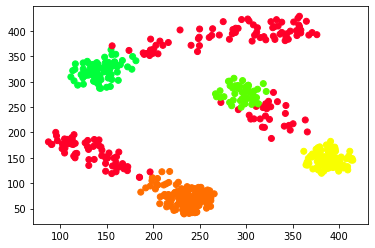

In [9]:
NUM_COLORS = 10
cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
plt.figure()
plt.scatter(data[:,0], data[:,1], c=scalarMap.to_rgba(labels))
plt.show()